In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings

from progressbar import *
import progressbar as pbar
from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD
from obspy.signal.spectral_estimation import get_nlnm, get_nhnm
from obspy.imaging.cm import pqlx

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

## 1. Initialisation des paramètres initiaux

In [3]:
### Paramètres généraux
load_data = False              # Recalculer les PPSDs et le déplacement RMS
freqs = [(2.0,8.0)]          # Bandes de fréquences à étudier 
st_name = ["G.CCD.00.BHZ"]  # Station à étudier
time_zone = "Europe/Brussels"
noise_input_data = "C:/Users/Arnaud/Desktop/Travail/Projet de Recherche/SeismicNoiseData"
PPSD_FOLDER  = "C:/Users/Arnaud/Desktop/Travail/Projet de Recherche/SeismicNoiseData/PPSD"
DRMS_FOLDER  = "C:/Users/Arnaud/Desktop/Travail/Projet de Recherche/SeismicNoiseData/DRMS"
MSEED_FOLDER = "C:/Users/Arnaud/Desktop/Travail/Projet de Recherche/SeismicNoiseData/MSEED"
timeseries_data = "Files/noise_timeseries/"
start = UTCDateTime("2010-01-01")    # Start Time
end = UTCDateTime("2020-12-31")      # End Time
datelist = pd.date_range(start.datetime, min(end, UTCDateTime()).datetime, freq="D")

##  2. Récupération des PPSDs

In [27]:
ppsds = {}

for station_str in st_name:
    for day in datelist:
        date_str = day.strftime("%Y-%m-%d")
        file_pattern = "{}/{}/{}_*.npz".format(PPSD_FOLDER, station_str, date_str)
        #print(file_pattern)
        #pbar.set_description("Reading data")

        for file in glob(file_pattern):
            mseedid = file.replace(".npz", "").split("_")[-1]

            if mseedid not in ppsds:
                ppsds[mseedid] = PPSD.load_npz(file, allow_pickle=True)
            else:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    ppsds[mseedid].add_npz(file, allow_pickle=True)

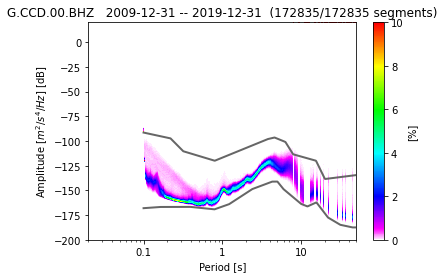

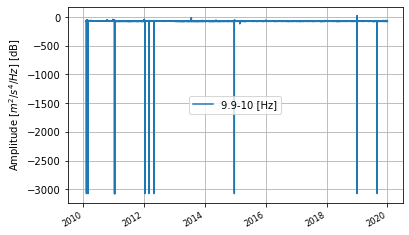

In [28]:
[ppsd.plot(max_percentage=10, grid=False, period_lim=(0.02,50), show_coverage=False, cmap=pqlx) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_temporal(0.10) for mseedid, ppsd in ppsds.items()]
if False : [ppsd.plot_spectrogram(clim=(-160,-100), grid=False) for mseedid, ppsd in ppsds.items()]
plt.show()

## 3. Récupération du déplacement RMS

In [18]:
dRMS = {}
for mseedid, ppsd in tqdm.tqdm(ppsds.items()):
    file = DRMS_FOLDER + "/" + mseedid + ".csv"
    df = pd.read_csv(file, index_col=0)
    df.index = pd.to_datetime(df.index)
    dRMS[mseedid] = df
dRMS

100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


{'G.CCD.00.BHZ':                          4.0-14.0  20.0-50.0
 2010-02-01 07:00:01  1.128134e-07        0.0
 2010-02-01 07:30:01  1.245853e-07        0.0
 2010-02-01 08:00:01  1.237054e-07        0.0
 2010-02-01 08:30:01  1.128019e-07        0.0
 2010-02-01 09:00:01  1.195153e-07        0.0
 ...                           ...        ...
 2020-12-01 21:30:00  7.780741e-08        0.0
 2020-12-01 22:00:00  8.809303e-08        0.0
 2020-12-01 22:30:00  8.181057e-08        0.0
 2020-12-01 23:00:00  7.616163e-08        0.0
 2020-12-01 23:30:00  8.799641e-08        0.0
 
 [188924 rows x 2 columns]}

C:\Users\Arnaud\Desktop\Travail\seismic-noise\seismosocialdistancing.py:726: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  rs = rs.resample("1D" ).median().tshift(12, "H")


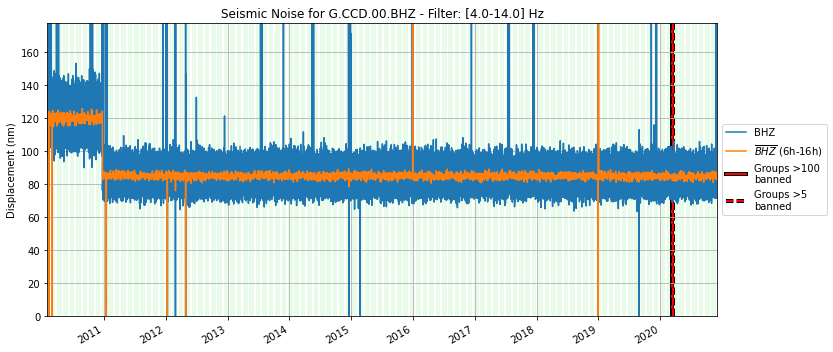

In [19]:
args = {'band':"4.0-14.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'logo':None,             # might be None or commented
        'unit':'nm'
       }
seismosocialdistancing.plot(dRMS,
                            type='timeseries',
                            **args)

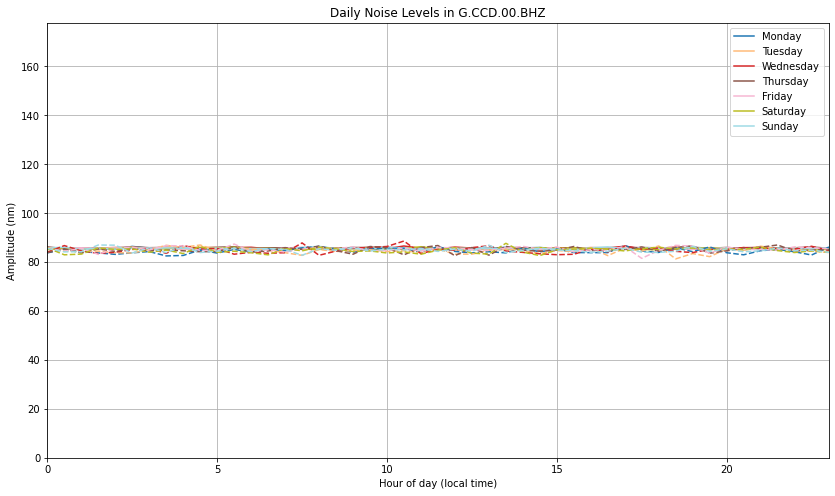

In [20]:
seismosocialdistancing.plot(dRMS,
                            type='dailyplots',
                            **args)

C:\Users\Arnaud\Desktop\Travail\seismic-noise\seismosocialdistancing.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.2g %s" %(i,unit) for i in ax.get_yticks()], fontsize=7)
C:\Users\Arnaud\Desktop\Travail\seismic-noise\seismosocialdistancing.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.2g %s" %(i,unit) for i in ax.get_yticks()], fontsize=7)


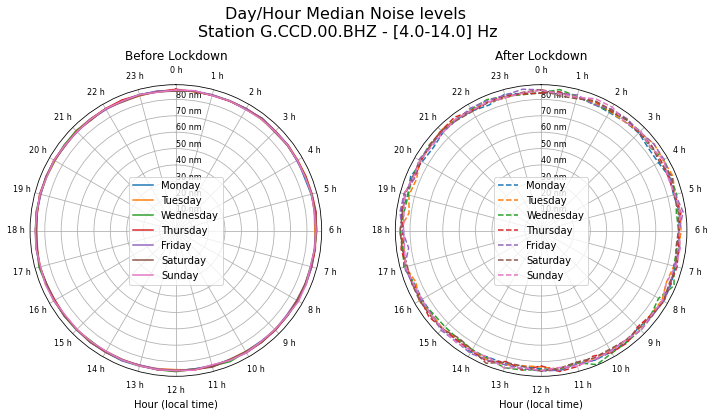

In [24]:
seismosocialdistancing.plot(dRMS,
                            type='clockplots',
                            **args)